<a href="https://colab.research.google.com/github/karencfisher/COVID19/blob/main/notebooks/covidradio_weighted_densenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

BASE_PATH = '/content/drive/MyDrive/COVID-19_Radiography_Dataset'
!unzip -q /content/drive/MyDrive/COVID-19_Radiography_Dataset/data.zip


Mounted at /content/drive


In [18]:
import os
import random
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report
from sklearn.utils import class_weight

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.layers import GlobalMaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
from keras.applications.densenet import DenseNet121, preprocess_input



#### Get metadata on training set 

In [3]:
classes = ('normal', 'COVID')
data_path = 'data'

counts = []
filelists = []
for item in classes:
    filelist = os.listdir(os.path.join(data_path, 'train', item))
    filelists.append(filelist)
    counts.append(len(filelist))


#### Visualize samples of the image data by class

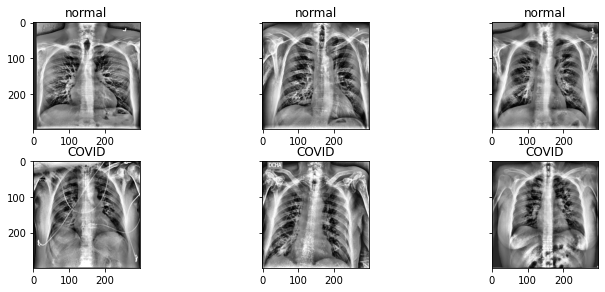

In [4]:
f, axes = plt.subplots(len(classes), 3, sharey=True)
f.set_figwidth(10)
plt.tight_layout()

for i, item in enumerate(classes):
    images = random.sample(filelists[i], 3)
    for j, image in enumerate(images):
        img_file = os.path.join(data_path, 'train', item, image)
        img = plt.imread(img_file)
        axes[i][j].imshow(img, cmap='gray')
        axes[i][j].set_title(item)


#### Plot prevalence of classes

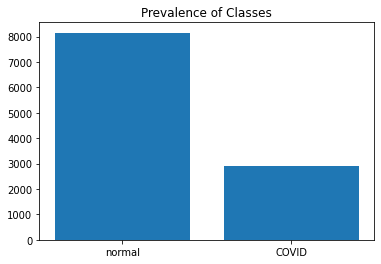

In [5]:
plt.bar(classes, counts)
plt.title('Prevalence of Classes');

#### Data generators to import images into the classifier

In [19]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_path = os.path.join(data_path, 'train')
train_gen = datagen.flow_from_directory(directory=train_path,
                    target_size=(299, 299),
                    batch_size=32,
                    shuffle=True,
                    class_mode='binary',
                    classes = classes)

valid_path = os.path.join(data_path, 'valid')
valid_gen = datagen.flow_from_directory(directory=valid_path,
                    target_size=(299, 299),
                    batch_size=32,
                    shuffle=False,
                    class_mode='binary',
                    classes = classes)

test_path = os.path.join(data_path, 'test')
test_gen = datagen.flow_from_directory(directory=test_path,
                    target_size=(299, 299),
                    batch_size=32,
                    shuffle=True,
                    class_mode='binary',
                    classes = classes)

Found 11045 images belonging to 2 classes.
Found 1380 images belonging to 2 classes.
Found 1383 images belonging to 2 classes.


In [20]:

base_model = DenseNet121(weights='imagenet', 
                         input_shape=(299, 299, 3),
                         include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

In [21]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 305, 305, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 150, 150, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 150, 150, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

#### Weighted binary crossentropy loss function

In [22]:
neg_w = np.sum(train_gen.classes) / len(train_gen.classes)
pos_w = 1 - neg_w

def Weighted_Loss(pos_w, neg_w, epsilon=1e-7):
  def weighted_loss(y_true, y_pred):
    pos_loss = -1 * K.mean(pos_w * y_true * K.log(y_pred + epsilon))
    neg_loss = -1 * K.mean(neg_w * (1 - y_true) * K.log(1 - y_pred + epsilon))
    loss = pos_loss + neg_loss
    return loss
  return weighted_loss

#### Compile and train

Epoch 1/25
346/346 [==============================] - 496s 1s/step - loss: 0.0651 - accuracy: 0.9405 - val_loss: 0.2295 - val_accuracy: 0.7471
Epoch 2/25
346/346 [==============================] - 475s 1s/step - loss: 0.0450 - accuracy: 0.9557 - val_loss: 1.5914 - val_accuracy: 0.8123
Epoch 3/25
346/346 [==============================] - 474s 1s/step - loss: 0.0457 - accuracy: 0.9550 - val_loss: 0.0487 - val_accuracy: 0.9493
Epoch 4/25
346/346 [==============================] - 475s 1s/step - loss: 0.0381 - accuracy: 0.9679 - val_loss: 1.2942 - val_accuracy: 0.7725
Epoch 5/25
346/346 [==============================] - 475s 1s/step - loss: 0.0297 - accuracy: 0.9699 - val_loss: 0.0285 - val_accuracy: 0.9725
Epoch 6/25
346/346 [==============================] - 474s 1s/step - loss: 0.0165 - accuracy: 0.9832 - val_loss: 0.0780 - val_accuracy: 0.8906
Epoch 7/25
346/346 [==============================] - 474s 1s/step - loss: 0.0186 - accuracy: 0.9823 - val_loss: 0.0327 - val_accuracy: 0.9616

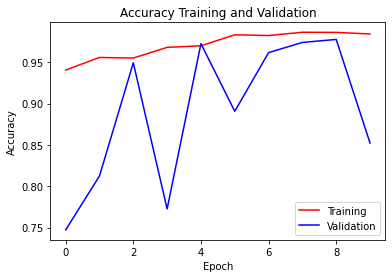

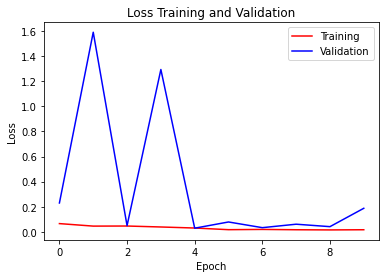

In [24]:
model.compile(loss=Weighted_Loss(pos_w, neg_w), optimizer='adam', metrics=['accuracy'])

stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

history = model.fit(train_gen,
                    epochs=25,
                    steps_per_epoch=len(train_gen),
                    validation_data=valid_gen,
                    validation_steps=len(valid_gen),
                    verbose=1,
                    callbacks=[stop, reduce_lr])

model_path = os.path.join(BASE_PATH, 'densenet_model.h5')
model.save(model_path)

plt.plot(history.history['accuracy'], 'r', label='Training')
plt.plot(history.history['val_accuracy'], 'b', label="Validation")
plt.title('Accuracy Training and Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc=0)
plt.show()

plt.plot(history.history['loss'], 'r', label='Training')
plt.plot(history.history['val_loss'], 'b', label="Validation")
plt.title('Loss Training and Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc=0)
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
model_path = os.path.join(BASE_PATH, 'densenet_model.h5')
model = load_model(model_path)

#### Evaluate the model

(Accuracy is not everything.)

In [25]:
score = model.evaluate(valid_gen)
print(f'Accuracy Score = {round(score[1], 2) * 100}%')

44/44 [==============================] - 18s 394ms/step - loss: 0.0285 - accuracy: 0.9725
Accuracy Score = 97.0%


#### Calculate confusion matrix, precision, recall, f1

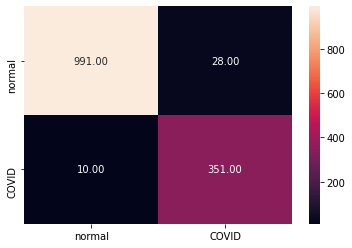

In [26]:
y_true = np.array(valid_gen.classes)
y_pred = model.predict(valid_gen)
y_pred = y_pred.reshape(-1)
y_pred = y_pred > 0.5
y_pred = y_pred.astype(np.uint8)

cf = confusion_matrix(y_true, y_pred)
sns.heatmap(cf, xticklabels=classes, yticklabels=classes, annot=True, fmt='.2f');

In [27]:
report = classification_report(y_true, y_pred, target_names=classes)
print(report)

              precision    recall  f1-score   support

      normal       0.99      0.97      0.98      1019
       COVID       0.93      0.97      0.95       361

    accuracy                           0.97      1380
   macro avg       0.96      0.97      0.96      1380
weighted avg       0.97      0.97      0.97      1380



#### ROC-AUC curve and AUC score

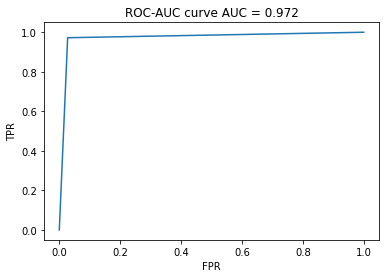

In [28]:
fpr, tpr, thresh = roc_curve(y_true, y_pred)
auc_score = round(roc_auc_score(y_true, y_pred), 3)
plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title(f'ROC-AUC curve AUC = {auc_score}')
plt.show()

#### Calculate Sensitivity, specificity, and PPV
Calculate PPV (Positive Predictive Value) using Bayes Theorem
 
 
$$ PPV = \frac{sensitivity \times prevalence}{sensitivity\times prevalence + (1 - specificty)\times(1 - prevalence)} $$

In [29]:
# tp, fp, tn, fn
tp = np.sum((y_true == 1) & (y_pred == 1))
fp = np.sum((y_true == 0) & (y_pred == 1))
tn = np.sum((y_true == 0) & (y_pred == 0))
fn = np.sum((y_true == 1) & (y_pred == 0))

# sensitivity, specificity
accuracy = (tp + tn) / (tp + tn + fp + fn)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print(f'Accuracy = {round(accuracy * 100, 2)}%')
print(f'Sensitivity = {round(sensitivity * 100, 2)}%')
print(f'Specificity = {round(specificity * 100, 2)}%')
    
# Calculate PPV according to Bayes Theorem
prev = np.sum(y_true) / len(y_true)
numerator = sensitivity * prev
denominator = sensitivity * prev + (1 - specificity) * (1 - prev)
ppv = numerator / denominator
print(f'Positive Predictive Value = {round(ppv * 100, 2)}%')


Accuracy = 97.25%
Sensitivity = 97.23%
Specificity = 97.25%
Positive Predictive Value = 92.61%
